In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_predict,cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score,f1_score,accuracy_score,precision_recall_curve,recall_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./performance.train.csv')
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
data = data.drop(labels='employee_id' ,axis=1)

In [4]:
data.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [5]:
data.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


#### Handling missing Data

In [7]:
data['previous_year_rating'].value_counts()

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64

In [8]:
data['previous_year_rating'].isnull().sum()

4124

In [9]:
#Assumption : No rating->Joined in current year
data['previous_year_rating'] = data['previous_year_rating'].replace({np.nan:'0'})

In [10]:
data['previous_year_rating'].isnull().sum()

0

In [11]:
data['education'].isnull().sum()

2409

In [12]:
# Assuming empty education field implies no degrees
data['education'] = data['education'].replace({None:'No Degrees'})

In [13]:
data.isnull().sum().sum()

0

#### With missing values handled we move to Exploratory Analysis

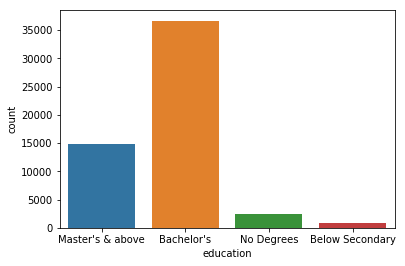

In [14]:
sns.countplot(data['education'])

In [15]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data_numeric = data.select_dtypes(include=numerics)

In [16]:
data_numeric.head()

,no_of_trainings,age,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,1,35,8,1,0,49,0
1,1,30,4,0,0,60,0
2,1,34,7,0,0,50,0
3,2,39,10,0,0,50,0
4,1,45,2,0,0,73,0


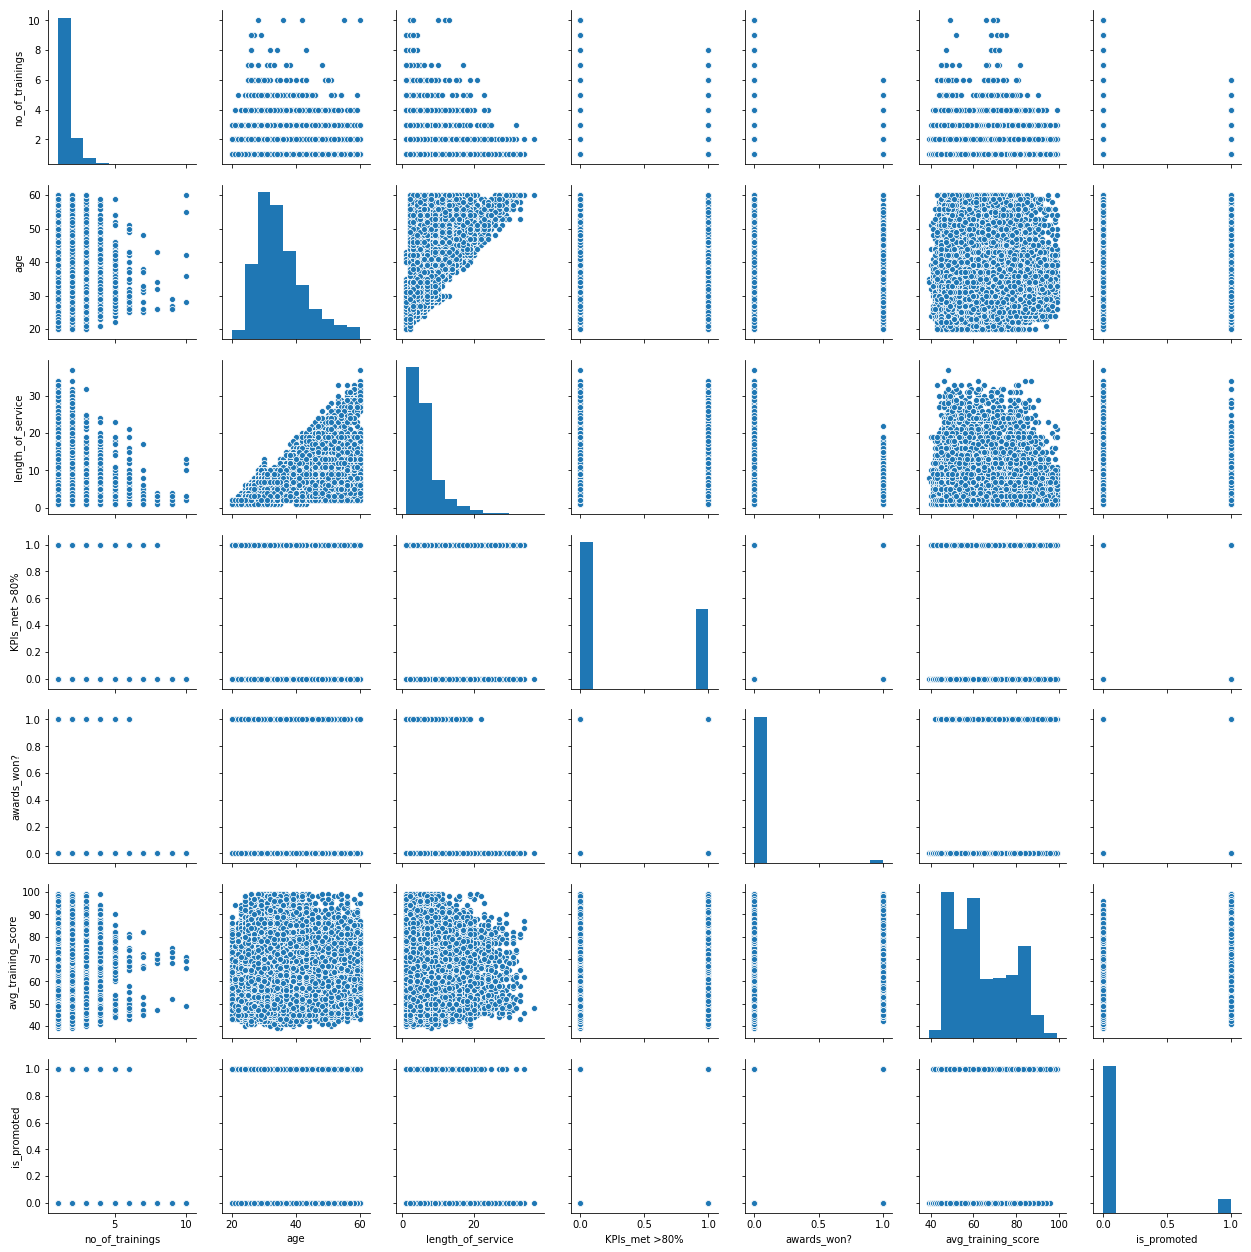

In [17]:
sns.pairplot(data_numeric)

In [18]:
data_numeric.corr()

,no_of_trainings,age,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.081278,-0.057275,-0.045576,-0.007628,0.042517,-0.024896
age,-0.081278,1.000000,0.657111,-0.025592,-0.008169,-0.048380,-0.017166
length_of_service,-0.057275,0.657111,1.000000,-0.077693,-0.039927,-0.038122,-0.010670
KPIs_met >80%,-0.045576,-0.025592,-0.077693,1.000000,0.097000,0.078391,0.221582
awards_won?,-0.007628,-0.008169,-0.039927,0.097000,1.000000,0.072138,0.195871
avg_training_score,0.042517,-0.048380,-0.038122,0.078391,0.072138,1.000000,0.181147
is_promoted,-0.024896,-0.017166,-0.010670,0.221582,0.195871,0.181147,1.000000


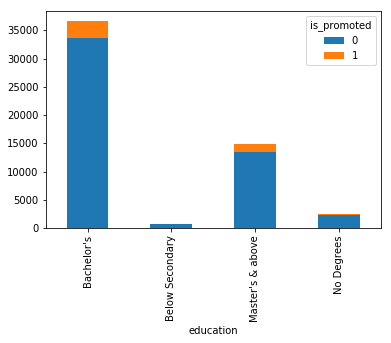

In [19]:
x = data.groupby(['education' , 'is_promoted']).size().unstack().plot(kind='bar' ,stacked=True)

##### Remark : No person without atleast a bachelor's degree was promoted

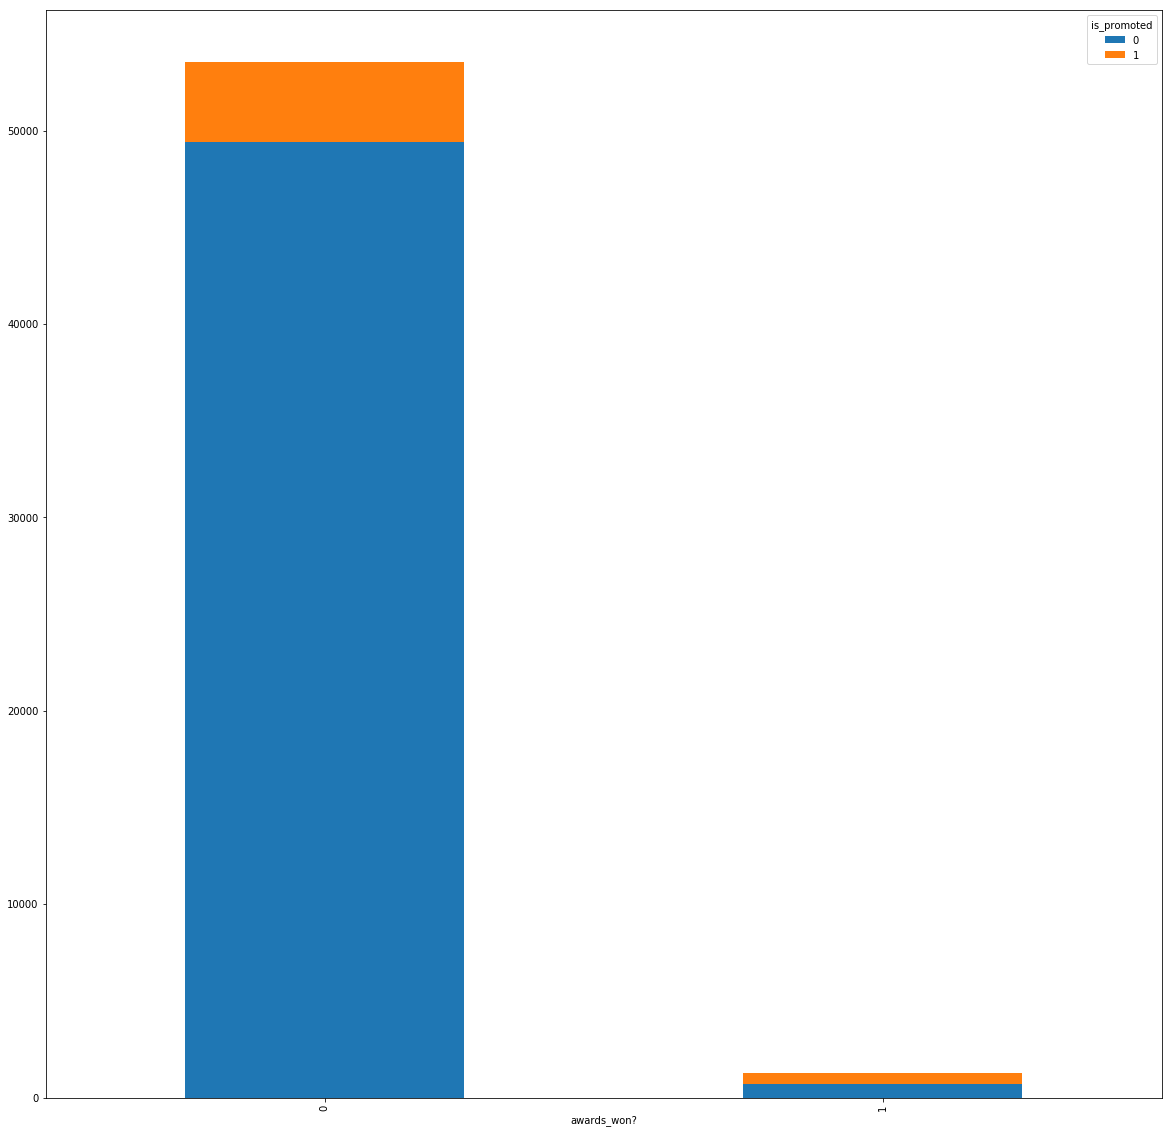

In [20]:
data.groupby(['awards_won?' , 'is_promoted']).size().unstack().plot(kind='bar',stacked=True,figsize=(20,20))

In [21]:
awards_infl = data.groupby(['awards_won?' , 'is_promoted']).size().unstack()

In [22]:
awards_infl['% promoted'] = awards_infl[1]/awards_infl.sum(axis=1)

In [23]:
awards_infl

is_promoted,0,1,% promoted
awards_won?,,,
0,49429,4109,0.076749
1,711,559,0.440157


##### Overall Promotion Rate : 8.5%
##### Promotion Rate among awardees : 44%

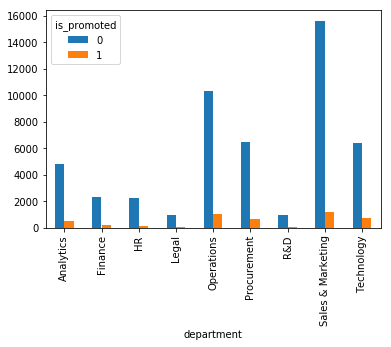

In [24]:
data.groupby(['department','is_promoted']).size().unstack().plot(kind='bar')

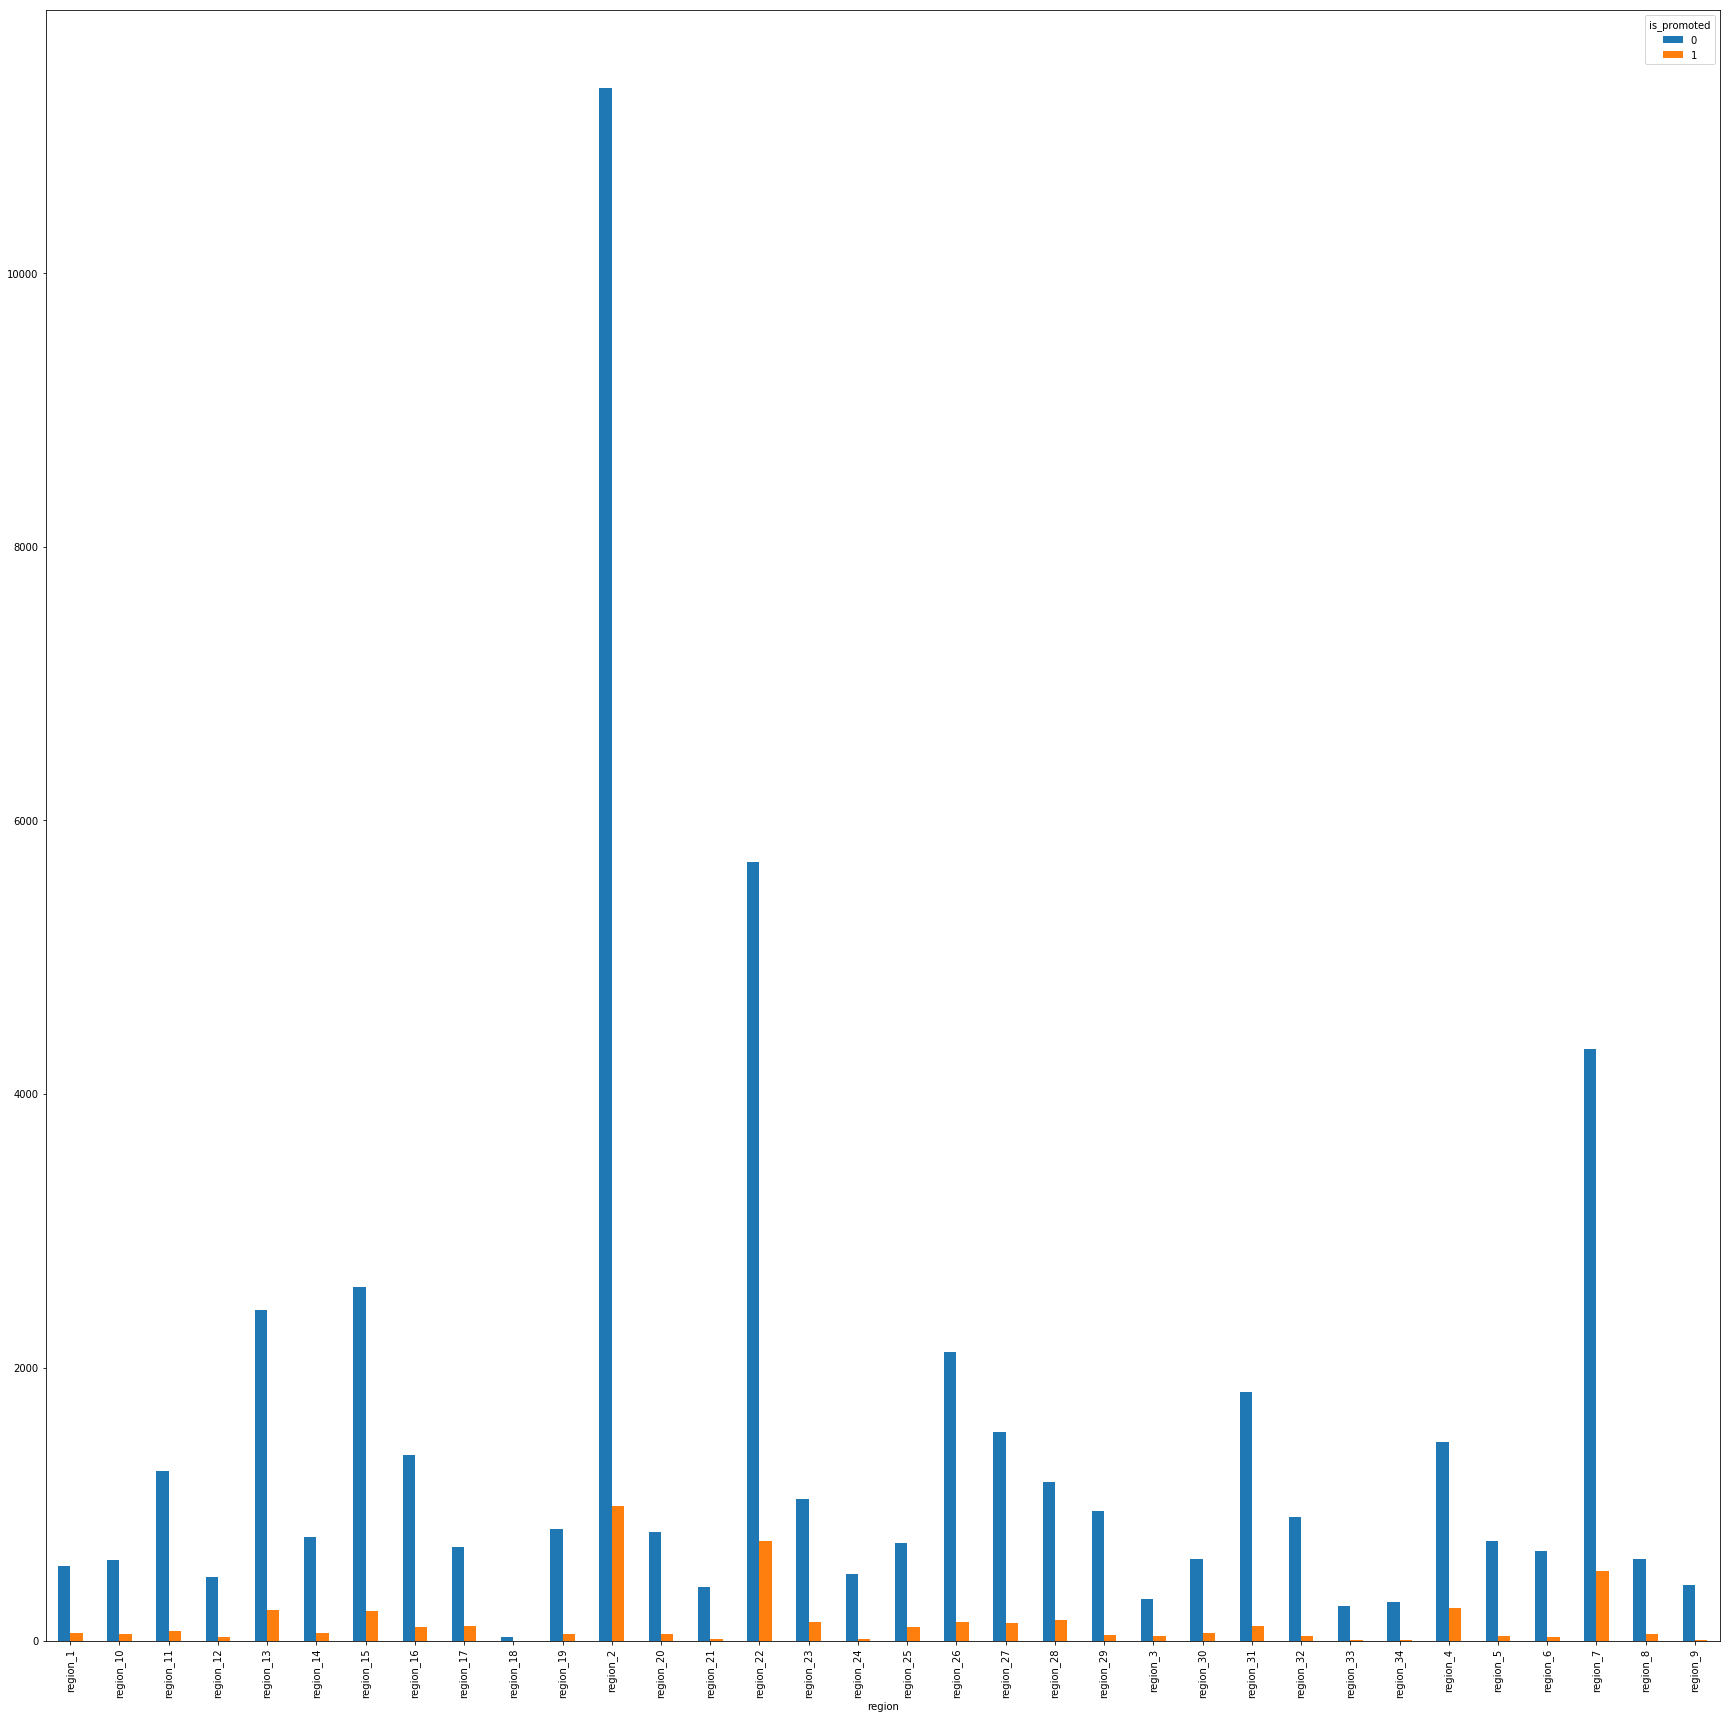

In [25]:
data.groupby(['region','is_promoted']).size().unstack().plot(kind='bar',figsize=(30,30))

##### Getting dataframe ready for modelling

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
department              54808 non-null object
region                  54808 non-null object
education               54808 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    54808 non-null object
length_of_service       54808 non-null int64
KPIs_met >80%           54808 non-null int64
awards_won?             54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: int64(7), object(6)
memory usage: 5.4+ MB


In [27]:
data['previous_year_rating'] = pd.to_numeric(data['previous_year_rating'])
data_categorical  = data.select_dtypes(include=[object])
data_categorical.head()

,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other


In [28]:
data_categorical = pd.get_dummies(data_categorical)

In [29]:
data_categorical.head()

,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,region_region_1,...,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,education_No Degrees,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,1,0,0


In [30]:
X = pd.concat([data.drop(labels=['department','region','education','gender','recruitment_channel'],axis=1),data_categorical],axis=1)

In [31]:
X.head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,department_Analytics,department_Finance,...,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,education_No Degrees,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,1,35,5.0,8,1,0,49,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1,1,30,5.0,4,0,0,60,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,1,34,3.0,7,0,0,50,0,0,0,...,0,1,0,0,0,0,1,0,0,1
3,2,39,1.0,10,0,0,50,0,0,0,...,0,1,0,0,0,0,1,1,0,0
4,1,45,3.0,2,0,0,73,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 60 columns):
no_of_trainings                 54808 non-null int64
age                             54808 non-null int64
previous_year_rating            54808 non-null float64
length_of_service               54808 non-null int64
KPIs_met >80%                   54808 non-null int64
awards_won?                     54808 non-null int64
avg_training_score              54808 non-null int64
is_promoted                     54808 non-null int64
department_Analytics            54808 non-null uint8
department_Finance              54808 non-null uint8
department_HR                   54808 non-null uint8
department_Legal                54808 non-null uint8
department_Operations           54808 non-null uint8
department_Procurement          54808 non-null uint8
department_R&D                  54808 non-null uint8
department_Sales & Marketing    54808 non-null uint8
department_Technology           54808 non

In [42]:
Y = X['is_promoted']
X.drop(labels='is_promoted',axis= 1 ,inplace=True)

### Ensemble Modelling

In [43]:
data_test = pd.read_csv('./performance.test.csv')
data_test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [60]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
employee_id             23490 non-null int64
department              23490 non-null object
region                  23490 non-null object
education               22456 non-null object
gender                  23490 non-null object
recruitment_channel     23490 non-null object
no_of_trainings         23490 non-null int64
age                     23490 non-null int64
previous_year_rating    21678 non-null float64
length_of_service       23490 non-null int64
KPIs_met >80%           23490 non-null int64
awards_won?             23490 non-null int64
avg_training_score      23490 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [67]:
data_test['education']=data_test['education'].fillna('No Degrees')
data_test['education'].isnull().sum()

0

In [68]:
data_test['previous_year_rating']=data_test['previous_year_rating'].fillna(0)

In [70]:
data_test.info()
data_test.isnull().sum().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
employee_id             23490 non-null int64
department              23490 non-null object
region                  23490 non-null object
education               23490 non-null object
gender                  23490 non-null object
recruitment_channel     23490 non-null object
no_of_trainings         23490 non-null int64
age                     23490 non-null int64
previous_year_rating    23490 non-null float64
length_of_service       23490 non-null int64
KPIs_met >80%           23490 non-null int64
awards_won?             23490 non-null int64
avg_training_score      23490 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


0

In [77]:
test_categorical = data_test.select_dtypes(include=object)
print(test_categorical.head())
test_cat_encoded = pd.get_dummies(test_categorical)

          department     region   education gender recruitment_channel
0         Technology  region_26  Bachelor's      m            sourcing
1                 HR   region_4  Bachelor's      f               other
2  Sales & Marketing  region_13  Bachelor's      m               other
3        Procurement   region_2  Bachelor's      f               other
4            Finance  region_29  Bachelor's      m            sourcing


In [81]:
X_test = pd.concat([data_test.drop(labels=['department','region','education','gender','recruitment_channel'],axis=1),test_cat_encoded],axis=1)

In [82]:
X_test.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,department_Analytics,department_Finance,...,region_region_9,education_Bachelor's,education_Below Secondary,education_Master's & above,education_No Degrees,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,8724,1,24,0.0,1,1,0,77,0,0,...,0,1,0,0,0,0,1,0,0,1
1,74430,1,31,3.0,5,0,0,51,0,0,...,0,1,0,0,0,1,0,1,0,0
2,72255,1,31,1.0,4,0,0,47,0,0,...,0,1,0,0,0,0,1,1,0,0
3,38562,3,31,2.0,9,0,0,65,0,0,...,0,1,0,0,0,1,0,1,0,0
4,64486,1,30,4.0,7,0,0,61,0,1,...,0,1,0,0,0,0,1,0,0,1


In [45]:
log_clf= LogisticRegression()
rf_clf = RandomForestClassifier()

voting_clf = VotingClassifier([('lr',log_clf),('rf',rf_clf)],voting='soft',n_jobs=-1)

In [46]:
clfs = [log_clf,rf_clf,voting_clf]

for clf in clfs:
    print(clf.__class__.__name__," has f1-> ",cross_val_score(clf,X,Y,cv=4,scoring='f1'))
    print(clf.__class__.__name__," has acc-> ",cross_val_score(clf,X,Y,cv=4,scoring='accuracy'))

LogisticRegression  has f1->  [0.38554217 0.38058252 0.37607973 0.37181208]
LogisticRegression  has acc->  [0.93300248 0.93015618 0.93146986 0.9316888 ]
RandomForestClassifier  has f1->  [0.38878266 0.38847118 0.36865768 0.3656051 ]
RandomForestClassifier  has acc->  [0.93271055 0.92898847 0.93117793 0.93044811]
VotingClassifier  has f1->  [0.39972991 0.38851802 0.4162234  0.38705327]
VotingClassifier  has acc->  [0.93409721 0.93438914 0.93395125 0.9337323 ]


In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [48]:
bg_clf = BaggingClassifier(DecisionTreeClassifier(),n_estimators=500,max_samples=0.4,n_jobs=-1,bootstrap=True)

In [49]:
print(bg_clf.__class__.__name__," has f1-> ",cross_val_score(clf,X,Y,cv=4,scoring='f1'))
print(bg_clf.__class__.__name__," has acc-> ",cross_val_score(clf,X,Y,cv=4,scoring='accuracy'))


BaggingClassifier  has f1->  [0.39136302 0.39464883 0.40936455 0.399462  ]
BaggingClassifier  has acc->  [0.93592176 0.93438914 0.93482703 0.93555685]


In [50]:
xgb_clf = xgb.XGBClassifier()

print(xgb_clf.__class__.__name__," has f1-> ",cross_val_score(clf,X,Y,cv=4,scoring='f1'))
print(xgb_clf.__class__.__name__," has acc-> ",cross_val_score(clf,X,Y,cv=4,scoring='accuracy'))

XGBClassifier  has f1->  [0.41471572 0.39383791 0.41798942 0.39273705]
XGBClassifier  has acc->  [0.93526492 0.9345351  0.93526492 0.93460809]


In [ ]:
""""
params ={ 'n_estimators':[400,600,800],
        'max_depth':[4,6,8],
        'reg_alpha':[0.1,0.3,0.4]}
"""
#xgb_cv = GridSearchCV(xgb_clf,params,scoring='f1',cv=3,n_jobs=-1)
#xgb_cv.fit(X,Y)
#print(xgb_cv.best_params_)



In [59]:
xgb_clf2 = xgb.XGBClassifier(max_depth=6,n_estimators=500,learning_rate=0.1,reg_alpha=0.3)

print(xgb_clf2.__class__.__name__," has f1-> ",cross_val_score(clf,X,Y,cv=4,scoring='f1').mean())
print(xgb_clf2.__class__.__name__," has acc-> ",cross_val_score(clf,X,Y,cv=4,scoring='accuracy').mean())

XGBClassifier  has f1->  0.39671364465203707
XGBClassifier  has acc->  0.9346445774339514


In [ ]:
Y_test_xgb